# Generación de Series Sintéticas
Notas de clase sobre la planificación centralizada de mercados eléctricos

**Juan David Velásquez Henao**   
jdvelasq@unal.edu.co  
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia  

[Licencia](https://github.com/jdvelasq/ETVL-R/blob/master/LICENCIA.txt)  
[Readme](https://github.com/jdvelasq/ETVL-R/blob/master/Readme.md)

**Software utilizado**.

> Este es un documento interactivo escrito como un notebook de [Jupyter](http://jupyter.org), en el cual se presenta un tutorial sobre la extracción, transformación, visualización y carga de datos usando **R** en el contexto de la ciencia de los datos. Los notebooks de Jupyter permiten incoporar simultáneamente código, texto, gráficos y ecuaciones. El código presentado en este notebook puede ejecutarse en los sistemas operativos Linux y OS X.

> Haga click [aquí](https://github.com/jdvelasq/guias-de-instalacion) para obtener instrucciones detalladas sobre como instalar Jupyter en Windows y Mac OS X.

> Haga clic [aquí](http://nbviewer.jupyter.org/github/jdvelasq/metodos-y-modelos/blob/master/02-07-aportes.ipynb) para ver la última versión de este documento en nbviewer.

> Descargue la última versión de este documento a su disco duro; luego, carguelo y ejecutelo en línea en [Try Jupyter!](https://try.jupyter.org)



#### Contenido

> 

# Introducción

En este documento se aborda el problema del modelo de series de aportes y caudales para la planificación de sistemas hidrotérmicos. Esta es una descripción muy simple tiene como fin describir los elementos básicos a tener en cuenta en este tipo de problemas. 

# Aportes totales al sistema hidroeléctrico colombiano

Las series hidrológicas tienen un nivel constante de largo plazo y un ciclo anual asociado a las estaciones. En la siguiente figura se presenta la gráfica de los aportes mensuales totales en energía al mercado eléctrico colombiano. El primer dato corresponde a 1995:08 y el último a 2014:03. Los máximos ocurren en julio y los mínimos en diciembre o enero.

Por reglamentación, el invierno va de mayo a noviembre (7 meses) y el verano de diciembre a abril (5 meses).

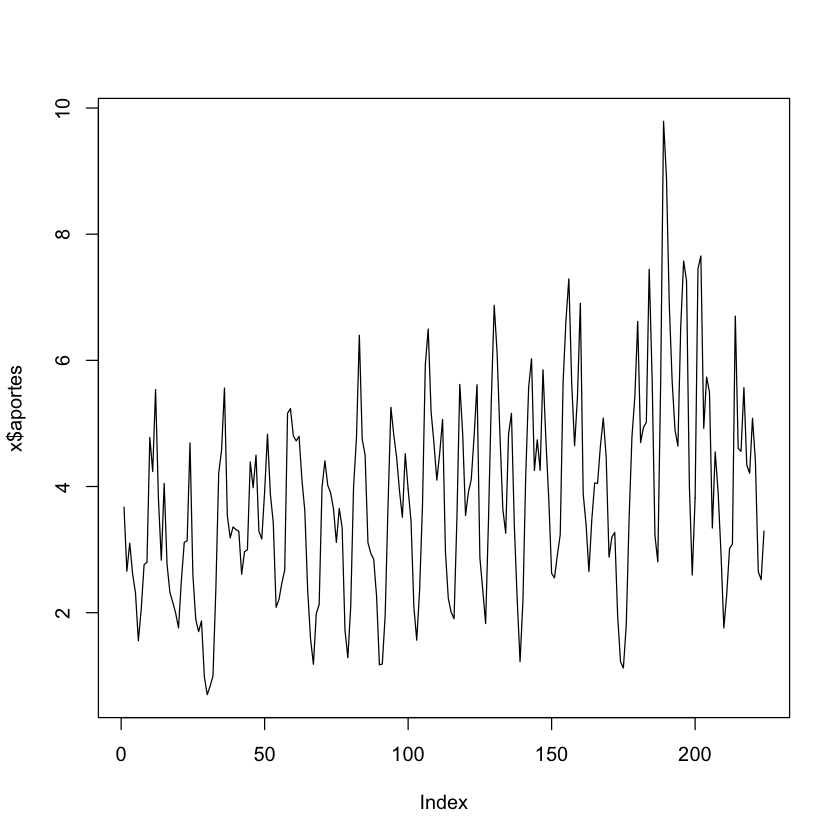

In [3]:
x <- read.table('aportes.txt', header = TRUE)
plot(x$aportes, type = 'l', col = 'black')

# Concepto de estacionariedad

Una serie de tiempo es estacionaria cuando su media y su varianza no cambian en el tiempo. Esto no se cumple para los aportes debido a la componente cíclica.

# Generación de series sintéticas

**Paso 1**

>Los aportes de cada mes se consideran una población diferente.

No es posible aplicar la estandarización directamente:

$z_t = \frac{x_t-\mu}{\sigma}$


Se estandariza usando la media y la población de cada mes:

$z_t = \frac{x_t - \mu_M}{\sigma_M}$

Con $M=$ enero, febrero, ...

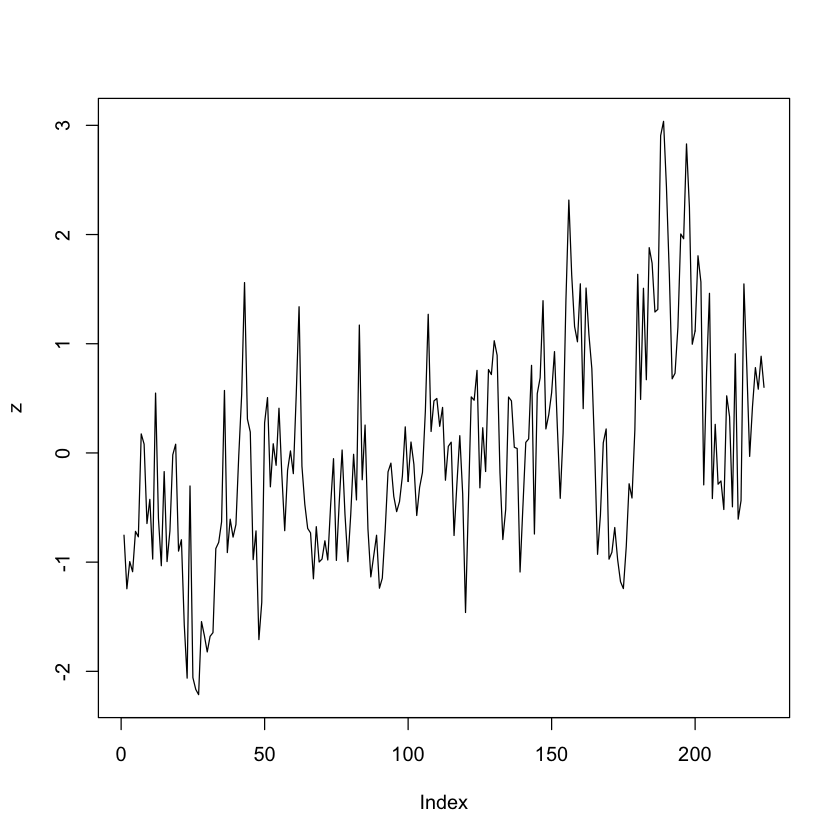

In [4]:
n = length(x$aportes)  # calcula la longitud de la serie
m = numeric(12)        # media de los doce meses del año
s = numeric(12)        # desv. estándard de los doce meses de año
z = numeric(n)         # serie de aportes estandarizada

for (mes in 1:12){
    k = seq(from = mes, to = n, by = 12)  # indices 
    m[mes] = mean(x$aportes[k])           # media muestral
    s[mes] = sd(x$aportes[k])             # desv estandar muestral
    z[k] = (x$aportes[k] - m[mes]) / s[mes]
}

plot(z, type = 'l', col = 'black')


**Paso 2**

La dinámica de estas series puede representarse como un modelo autorregresivo de orden $P$:

$z_t = \phi_0 + \sum_{k=1}^P \phi_k z_{t-k} + e_t$

Con:
* $\phi_k,  k = 1, ...,P$ son los coeficientes del modelo.
* $\phi_0$ es el intercepto.
* $e_t$ es una variable aleatoria normal con media cero y varianza $\sigma^2$

El modelo óptimo puede estimarse usando `ar.ols`.


In [5]:
u = ar.ols(z, ord.max = 12)
u 


Call:
ar.ols(x = z, ord.max = 12)

Coefficients:
     1       2       3  
0.5859  0.0770  0.1314  

Intercept: 0.01132 (0.04434) 

Order selected 3  sigma^2 estimated as  0.4343

## Generación de una serie sintética

Para este caso se calcularía como:

$z_t = 0.01132 + 0.5859 z_{t-1} + 0.0770 z_{t-2} + 0.1314 z_{t-3} + e_t$

y

$e_t = $ `sqrt(0.4343) * rnorm(1)`

En el siguiente ejemplo se generan 1000 datos sintéticos adicionales.


In [6]:
H = 1000
y = c(z, numeric(H))
for (t in (n+1):(n+H)) {
    y[t] = 0.01132 + 0.5859 * y[t-1] + 0.0770 * y[t-2] + 0.1314 * y[t-3]
    y[t] = y[t] + sqrt(0.4343) * rnorm(1)
}

In [7]:
# Hay que invertir la estandarizacion
for (mes in 1:12){
    k = seq(from = mes, to = n+H, by = 12)  # indices 
    y[k] = y[k] * s[mes] + m[mes]
}

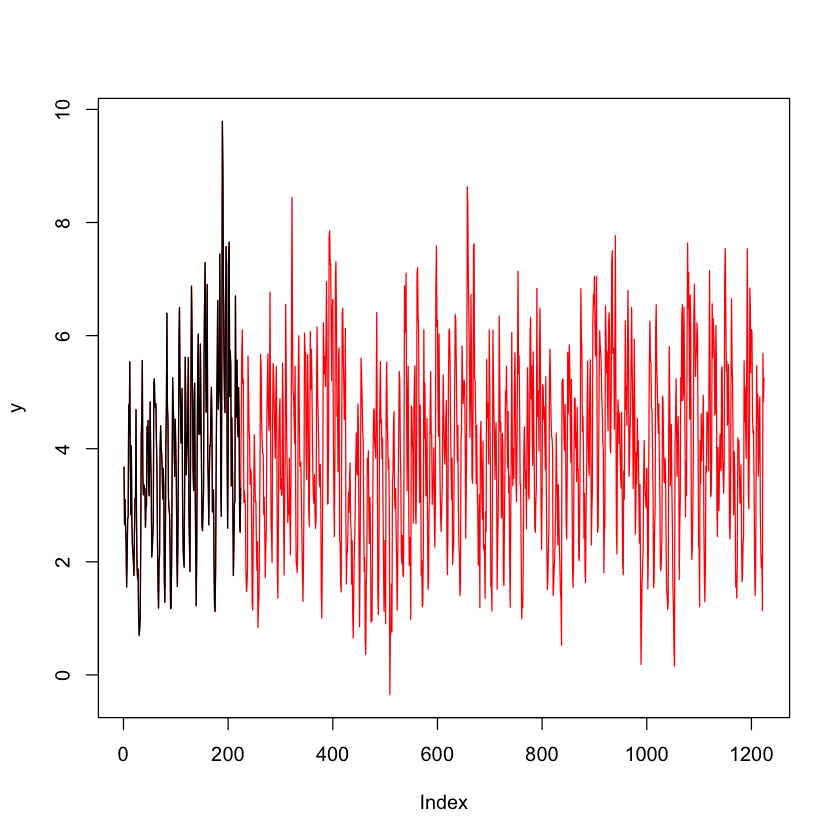

In [8]:
plot(y, type = 'l', col = 'red')
lines(x$aportes, col = 'black')

**Nota sobre MPODE**

Se estima por defecto un modelo AR(1).

Las series para cada planta hidráulica se generan de forma independiente. Esto implica que una cuenca puede estar en régimen de Niño y la vecina en régimen de Niña (!!!). 

# Programación lineal estocástica

Se considera que los aportes son estocásticos. Existen dos mecanismos de modelado:

* Implicita: Se generan muchas series sintéticas y se resuelve el modelo para cada serie sintética.

* Explicita: Representación estocástica de los caudales. En las aproximaciones más tradicionales se discretizan los caudales y se usan matrices de probabilidad de transición.


---

**Ejercicio.--**  Estime un modelo AR(1) para la generación de series sintéticas de caudales para la planta hidraulica de la actividad anterior.

---

[Contenido](#Contenido)